Notebook para realizar el EDA del dataset

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [3]:
raw_data = pd.read_csv('../datasets/loan_default_data.csv', encoding='latin1')
raw_data.head()

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_length,...,total_acc,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,repay_fail
0,2,2,2,0.0,0.0,0.0,36 months,0.00,0.00,< 1 year,...,1.0,0.000000,0.00,0.00,0.00,Jan-07,0.00,Jan-07,Jan-07,1
1,3,545583,703644,2500.0,2500.0,2500.0,36 months,13.98,85.42,4 years,...,10.0,3075.291779,3075.29,2500.00,575.29,Jul-13,90.85,Aug-13,Jun-16,0
2,4,532101,687836,5000.0,5000.0,5000.0,36 months,15.95,175.67,4 years,...,15.0,2948.760000,2948.76,1909.02,873.81,Nov-11,175.67,NaN,Mar-12,1
3,5,877788,1092507,7000.0,7000.0,7000.0,36 months,9.91,225.58,10+ years,...,20.0,8082.391880,8082.39,7000.00,1082.39,Mar-14,1550.27,NaN,Mar-14,0
4,6,875406,1089981,2000.0,2000.0,2000.0,36 months,5.42,60.32,10+ years,...,15.0,2161.663244,2161.66,2000.00,161.66,Feb-14,53.12,NaN,Jun-16,0


Utilizamos `encoding='latin1'` porque al parecer el notebook contiene caracteres que no se pueden decodificar usando el default de `pd.read_csv`

### Columnas a eliminar

1. Podemos ver que **Unnamed: 0** parece ser un índice que se añadió en algún punto del proceso de compilación de datos, por lo que no es necesario mantenerlo.
2. **zip_code** es tal vez demasiado específico para los fines de este proyecto, por lo cual también será eliminado.
3. No tenemos una tabla adicional de clientes o préstamos, por lo que **member_id** y **id** también pueden ser descartados.
4. No nos interesa la fecha del pago siguiente ya que solo queremos ver si hay morosidad.
5. También deshagamonos de **last_credit_pull_d**

### Otras observaciones

* Vemos que la primera fila parece ser algún tipo de error, ya que describe un préstamo de $0. Sería bueno ver si hay otras instancias así y eliminarlas.
* Term parece ser el número de meses que dura el préstamo. Sería bueno reemplazarlo por una columna numérica llamada "term_months"
* Existen algunas columnas relacionadas con el historial crediticio, pero cuya relación con la morosidad podría ser inconsistente, tal vez sea apropiado removerlas en pasos siguientes. Muchas de estas parecen ser redundantes entre si. Eliminar **earliest_cr_line, inq_last_6mths, revol_bal, revol_util, total_acc**.
* Para los fines de este análisis, nos interesa solamente cuanto se ha pagado, eliminar **total_ptmnt_inv**.
* Habría que ver que tanta diferencia hay entre las filas loan_amnt, funded_amnt, y funded_amnt_inv. Tal vez sea buena idea mantener solamente una de las tres.
* Las fechas parecen estar en un formato *mes-año*, encontrar la manera de verificar que sea el caso. El dataset se actualizó por última vez en el 2023, por lo que no debería haber valores mayores a 23 en la parte del año (Luego de eliminar ciertas columnas se comprobó que los dígitos si corresponden al año).

In [4]:
# Eliminemos las columnas que no nos interesan
columns_to_drop = ['Unnamed: 0', 'zip_code', 'member_id', 'id', 'last_credit_pull_d',
                   'next_pymnt_d', 'earliest_cr_line', 'inq_last_6mths', 'revol_bal',
                   'revol_util', 'total_acc']
raw_data = raw_data.drop(columns=columns_to_drop)

raw_data.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_length,home_ownership,annual_inc,verification_status,...,mths_since_last_delinq,open_acc,pub_rec,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,last_pymnt_d,last_pymnt_amnt,repay_fail
0,0.0,0.0,0.0,36 months,0.00,0.00,< 1 year,RENT,0.0,Not Verified,...,NaN,0.0,0.0,0.000000,0.00,0.00,0.00,Jan-07,0.00,1
1,2500.0,2500.0,2500.0,36 months,13.98,85.42,4 years,RENT,20004.0,Not Verified,...,NaN,7.0,0.0,3075.291779,3075.29,2500.00,575.29,Jul-13,90.85,0
2,5000.0,5000.0,5000.0,36 months,15.95,175.67,4 years,RENT,59000.0,Not Verified,...,59.0,7.0,0.0,2948.760000,2948.76,1909.02,873.81,Nov-11,175.67,1
3,7000.0,7000.0,7000.0,36 months,9.91,225.58,10+ years,MORTGAGE,53796.0,Not Verified,...,3.0,7.0,0.0,8082.391880,8082.39,7000.00,1082.39,Mar-14,1550.27,0
4,2000.0,2000.0,2000.0,36 months,5.42,60.32,10+ years,RENT,30000.0,Not Verified,...,72.0,7.0,0.0,2161.663244,2161.66,2000.00,161.66,Feb-14,53.12,0


In [5]:
# Veamos el número de valores nulos en las columnas
nan_counts = raw_data.isnull().sum()
print(nan_counts)

loan_amnt                     1
funded_amnt                   1
funded_amnt_inv               1
term                          0
int_rate                      0
installment                   1
emp_length                  993
home_ownership                0
annual_inc                    2
verification_status           0
issue_d                       0
loan_status                   0
purpose                       0
addr_state                    0
dti                           0
delinq_2yrs                   1
mths_since_last_delinq    24363
open_acc                      1
pub_rec                       1
total_pymnt                   1
total_pymnt_inv               1
total_rec_prncp               1
total_rec_int                 1
last_pymnt_d                 71
last_pymnt_amnt               1
repay_fail                    0
dtype: int64


Parece ser que tenemos una fila con errores ademas de la primera que contiene ceros. Considerar eliminarla.

Podemos observar ciertos valores NaN presentes en mayor cantidad en ciertas columnas:

* emp_lenght: podrian ser personas desempleadas, verificar con annual_inc como se ven los ingresos de estas personas. Considerar reemplazar con ceros.
* mths_since_last_delinq: la interpretación obvia es que son personas que no han tenido problemas con los pagos. Verificar el rango de valores, e inputar un valor alto para estas personas.
* last_pymnt_d: quizás son personas que nunca realizaron un pago. Se podría generar una columna time_to_delinq para explorar si hay alguna relación entre las otras columnas y el tiempo en el cuál dejan de recibirse pagos después de que una persona ha sacado un préstamo. Considerar inputar issue_d en estos valores para realizar el cálculo.

In [6]:
rows_with_nan_open_acc = raw_data[raw_data['open_acc'].isnull()]
print(rows_with_nan_open_acc)

    loan_amnt  funded_amnt  funded_amnt_inv       term  int_rate  installment  \
54        NaN          NaN              NaN  60 months    100.99          NaN   

   emp_length home_ownership  annual_inc verification_status  ...  \
54  10+ years       MORTGAGE         NaN            Verified  ...   

   mths_since_last_delinq open_acc pub_rec total_pymnt  total_pymnt_inv  \
54                    0.0      NaN     NaN         NaN              NaN   

    total_rec_prncp  total_rec_int  last_pymnt_d  last_pymnt_amnt  repay_fail  
54              NaN            NaN        Jan-99              NaN           0  

[1 rows x 26 columns]


In [7]:
print(raw_data.iloc[52:57])

    loan_amnt  funded_amnt  funded_amnt_inv       term  int_rate  installment  \
52    10000.0       9550.0      9418.065777  60 months     10.75       206.46   
53    12000.0      12000.0     11955.059290  36 months     12.73       402.77   
54        NaN          NaN              NaN  60 months    100.99          NaN   
55    19250.0      19250.0     19250.000000  60 months     14.79       455.84   
56    11000.0      11000.0     10975.000000  60 months     10.37       235.73   

   emp_length home_ownership  annual_inc verification_status  ...  \
52    5 years       MORTGAGE     75000.0        Not Verified  ...   
53    4 years            OWN     31000.0        Not Verified  ...   
54  10+ years       MORTGAGE         NaN            Verified  ...   
55    8 years       MORTGAGE     65004.0            Verified  ...   
56  10+ years       MORTGAGE     48000.0            Verified  ...   

   mths_since_last_delinq open_acc pub_rec  total_pymnt  total_pymnt_inv  \
52                    

Vemos que la fila 54 no aporta mucho, y tampoco causa algún problema en registros cercanos (los valores de las filas anteriores y subsequentes parecen tener sentido). Por lo tanto eliminaremos esta fila durante el data wrangling.

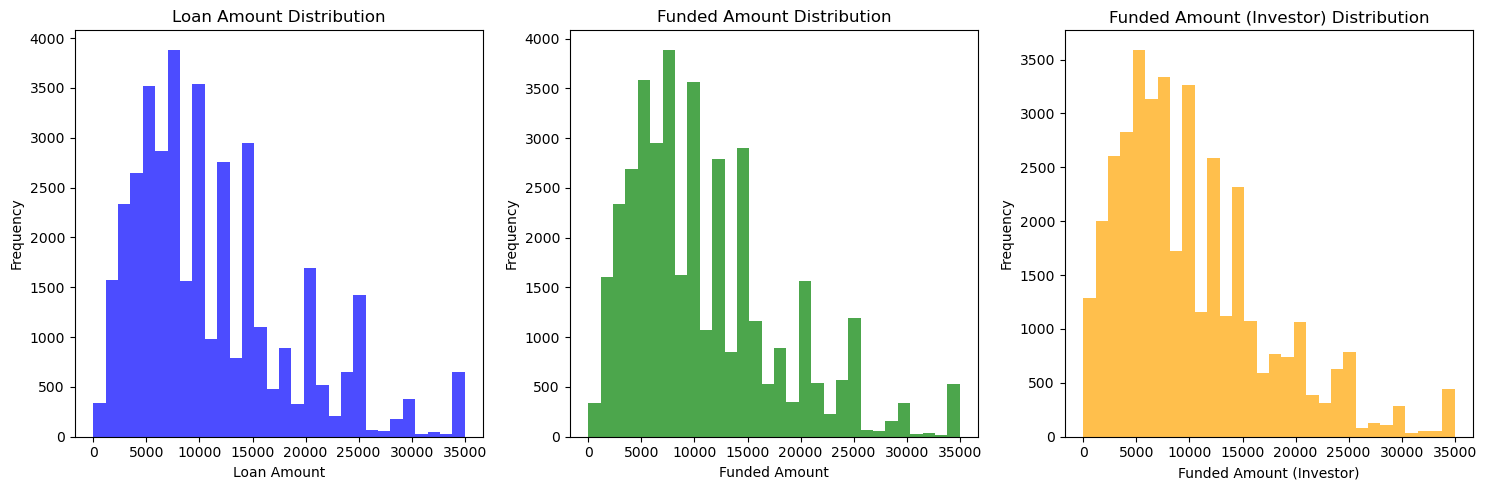

In [8]:
# Analicemos las columnas, empezemos creando histogramas de loan_amnt, funded_amnt,
# y funded_amnt_inv para ver si tienen distribuciones similares
plt.figure(figsize=(15, 5))
# Histograma loan_amnt
plt.subplot(1, 3, 1)
plt.hist(raw_data['loan_amnt'], bins=30, color='blue', alpha=0.7)
plt.title('Loan Amount Distribution')
plt.xlabel('Loan Amount')
plt.ylabel('Frequency')

# Histograma funded_amnt
plt.subplot(1, 3, 2)
plt.hist(raw_data['funded_amnt'], bins=30, color='green', alpha=0.7)
plt.title('Funded Amount Distribution')
plt.xlabel('Funded Amount')
plt.ylabel('Frequency')

# Histograma  funded_amnt_inv
plt.subplot(1, 3, 3)
plt.hist(raw_data['funded_amnt_inv'], bins=30, color='orange', alpha=0.7)
plt.title('Funded Amount (Investor) Distribution')
plt.xlabel('Funded Amount (Investor)')
plt.ylabel('Frequency')

# Show the plots
plt.tight_layout()
plt.show()

Las distribuciones son bastante similares, podríamos considerar quedarnos solo con loan_amnt y eliminar **funded_amnt** y **funded_amnt_inv**.

In [9]:
raw_data = raw_data.drop(columns=['funded_amnt','funded_amnt_inv'])
raw_data.head()

,loan_amnt,term,int_rate,installment,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,...,mths_since_last_delinq,open_acc,pub_rec,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,last_pymnt_d,last_pymnt_amnt,repay_fail
0,0.0,36 months,0.00,0.00,< 1 year,RENT,0.0,Not Verified,Dec-99,Charged Off,...,NaN,0.0,0.0,0.000000,0.00,0.00,0.00,Jan-07,0.00,1
1,2500.0,36 months,13.98,85.42,4 years,RENT,20004.0,Not Verified,Jul-10,Does not meet the credit policy. Status:Fully ...,...,NaN,7.0,0.0,3075.291779,3075.29,2500.00,575.29,Jul-13,90.85,0
2,5000.0,36 months,15.95,175.67,4 years,RENT,59000.0,Not Verified,Jun-10,Charged Off,...,59.0,7.0,0.0,2948.760000,2948.76,1909.02,873.81,Nov-11,175.67,1
3,7000.0,36 months,9.91,225.58,10+ years,MORTGAGE,53796.0,Not Verified,Sep-11,Fully Paid,...,3.0,7.0,0.0,8082.391880,8082.39,7000.00,1082.39,Mar-14,1550.27,0
4,2000.0,36 months,5.42,60.32,10+ years,RENT,30000.0,Not Verified,Sep-11,Fully Paid,...,72.0,7.0,0.0,2161.663244,2161.66,2000.00,161.66,Feb-14,53.12,0


In [10]:
# Ahora examinemos int_rate
raw_data['int_rate'].describe()

count    38480.00000
mean        12.16430
std          3.73744
min          0.00000
25%          9.62000
50%         11.99000
75%         14.72000
max        100.99000
Name: int_rate, dtype: float64

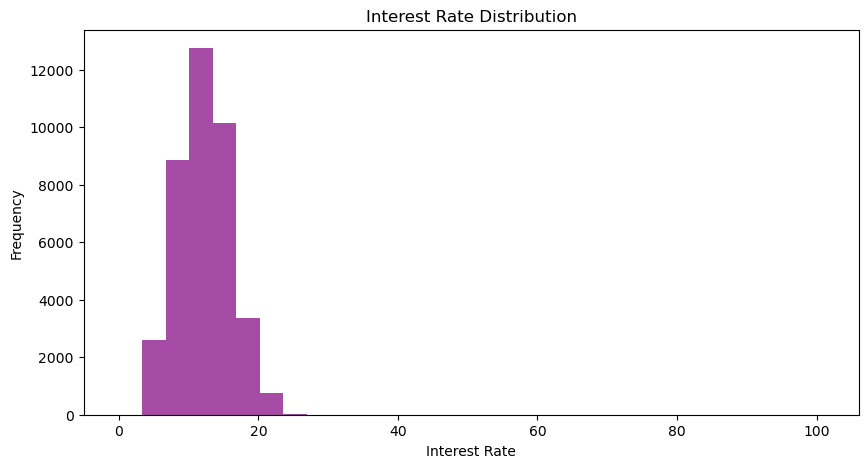

In [11]:
plt.figure(figsize=(10, 5))
plt.hist(raw_data['int_rate'], bins=30, color='purple', alpha=0.7) 
plt.title('Interest Rate Distribution')
plt.xlabel('Interest Rate')
plt.ylabel('Frequency')
plt.show()

In [12]:
top_3_int_rate = raw_data['int_rate'].nlargest(3)
print(top_3_int_rate)
low_3_int_rate = raw_data['int_rate'].nsmallest(3)
print(low_3_int_rate)

54       100.99
5761      24.11
23818     24.11
Name: int_rate, dtype: float64
0     0.00
4     5.42
47    5.42
Name: int_rate, dtype: float64


Parece ser que fuera de los valores de la primera fila (0) y de la fila 54 (100.99), no tenemos outliers en interest rate.

In [13]:
# Examinemos la columna term
term_summary = raw_data['term'].value_counts()
print(term_summary)

term
36 months    28593
60 months     9887
Name: count, dtype: int64


Solo hay dos valores en esta fila, considerar reemplazar la columna por una variable boolean long_term que sea True para prestamos de 60 meses y False para prestamos de 36 meses

In [14]:
# Examinemos la columna installment
top_3_installment = raw_data['installment'].nlargest(3)
print(top_3_installment)
low_3_installment = raw_data['installment'].nsmallest(3)
print(low_3_installment)
raw_data['installment'].describe()

12927    1305.19
20821    1302.69
5397     1295.21
Name: installment, dtype: float64
0         0.00
36536    15.67
24998    15.69
Name: installment, dtype: float64


count    38479.000000
mean       323.163255
std        209.089097
min          0.000000
25%        165.740000
50%        277.980000
75%        429.350000
max       1305.190000
Name: installment, dtype: float64

In [15]:
# Examinemos la columna employment_length
emp_length_summary = raw_data['emp_length'].value_counts(dropna=False)
print(emp_length_summary)

emp_length
10+ years    8465
< 1 year     4565
2 years      4292
3 years      3939
4 years      3314
1 year       3254
5 years      3171
6 years      2144
7 years      1702
8 years      1445
9 years      1196
NaN           993
Name: count, dtype: int64


In [16]:
# Examinemos la columna home_ownership
home_ownership_summary = raw_data['home_ownership'].value_counts(dropna=False)
print(home_ownership_summary)

home_ownership
RENT        18253
MORTGAGE    17140
OWN          2958
OTHER         125
NONE            4
Name: count, dtype: int64


In [17]:
# Examinemos la columna annual_inc
pd.set_option('display.float_format', '{:.2f}'.format)

# Describe the annual_inc column again
print(raw_data['annual_inc'].describe())

count     38478.00
mean      68995.31
std       64476.39
min           0.00
25%       40000.00
50%       58650.00
75%       82000.00
max     6000000.00
Name: annual_inc, dtype: float64


In [18]:
top_10_annual_inc = raw_data['annual_inc'].nlargest(10)
print(top_10_annual_inc)

6308    6000000.00
30071   3900000.00
19952   2039784.00
18171   1782000.00
9430    1440000.00
11025   1440000.00
37295   1362000.00
30890   1250000.00
18476   1200000.00
31205   1200000.00
Name: annual_inc, dtype: float64


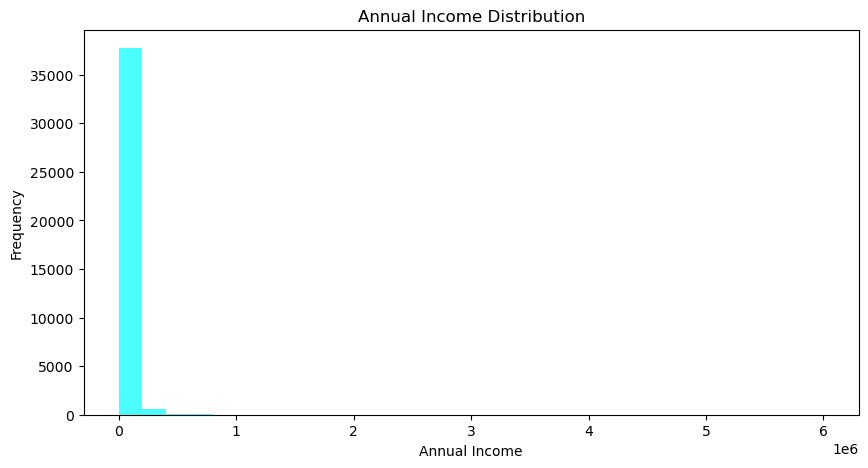

In [19]:
# Creemos un histograma de la columna annual_inc
plt.figure(figsize=(10, 5))
plt.hist(raw_data['annual_inc'], bins=30, color='cyan', alpha=0.7)
plt.title('Annual Income Distribution')
plt.xlabel('Annual Income')
plt.ylabel('Frequency')
plt.show()

Installment, home ownership y employment length no parecen tener problemas además de los NaN ya mencionados.

En annual_inc, tal vez deberíamos considerar eliminar las filas con ingresos superiores a $1 millon anuales.

In [20]:
raw_data.head()

,loan_amnt,term,int_rate,installment,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,...,mths_since_last_delinq,open_acc,pub_rec,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,last_pymnt_d,last_pymnt_amnt,repay_fail
0,0.00,36 months,0.00,0.00,< 1 year,RENT,0.00,Not Verified,Dec-99,Charged Off,...,NaN,0.00,0.00,0.00,0.00,0.00,0.00,Jan-07,0.00,1
1,2500.00,36 months,13.98,85.42,4 years,RENT,20004.00,Not Verified,Jul-10,Does not meet the credit policy. Status:Fully ...,...,NaN,7.00,0.00,3075.29,3075.29,2500.00,575.29,Jul-13,90.85,0
2,5000.00,36 months,15.95,175.67,4 years,RENT,59000.00,Not Verified,Jun-10,Charged Off,...,59.00,7.00,0.00,2948.76,2948.76,1909.02,873.81,Nov-11,175.67,1
3,7000.00,36 months,9.91,225.58,10+ years,MORTGAGE,53796.00,Not Verified,Sep-11,Fully Paid,...,3.00,7.00,0.00,8082.39,8082.39,7000.00,1082.39,Mar-14,1550.27,0
4,2000.00,36 months,5.42,60.32,10+ years,RENT,30000.00,Not Verified,Sep-11,Fully Paid,...,72.00,7.00,0.00,2161.66,2161.66,2000.00,161.66,Feb-14,53.12,0


In [21]:
# Examinemos la columna verification_status
verification_status_summary = raw_data['verification_status'].value_counts(dropna=False)
print(verification_status_summary)

verification_status
Not Verified       16962
Verified           12170
Source Verified     9348
Name: count, dtype: int64


Podriamos reemplazar esta columna por una boolean llamada "employment_verified", juntando los vaalores Verified y Source Verified

In [22]:
# Examinemos la columna purpose
purpose_summary = raw_data['purpose'].value_counts(dropna=False)
print(purpose_summary)

purpose
debt_consolidation    17917
credit_card            4974
other                  3950
home_improvement       2901
major_purchase         2079
small_business         1808
car                    1481
wedding                 909
medical                 675
moving                  562
house                   387
educational             386
vacation                360
renewable_energy         91
Name: count, dtype: int64


Esta columna podría ser útil, dejarla como está.

In [23]:
# Examinemos loan_status
loan_status_summary = raw_data['loan_status'].value_counts(dropna=False)
print(loan_status_summary)

loan_status
Fully Paid                                             29987
Charged Off                                             5111
Does not meet the credit policy. Status:Fully Paid      1782
Current                                                  867
Does not meet the credit policy. Status:Charged Off      689
Late (31-120 days)                                        20
In Grace Period                                           15
Late (16-30 days)                                          7
Default                                                    2
Name: count, dtype: int64


Consolidar categorias: Paid, Charged Off (Incluir Default), Current (Incluir Grace Period), Late

Esto también vuelve un tanto redundante a la columna 'repay_fail'

In [24]:
# Examinemos la columna address_state
address_state_summary = raw_data['addr_state'].value_counts(dropna=False)
print(address_state_summary)

addr_state
CA    6754
NY    3702
FL    2803
TX    2633
NJ    1795
IL    1523
PA    1491
GA    1371
VA    1343
MA    1285
OH    1209
MD    1010
AZ     856
WA     798
CO     771
NC     747
CT     722
MI     708
MO     677
MN     597
NV     485
WI     473
AL     439
SC     438
OR     419
LA     415
KY     313
OK     284
KS     271
UT     254
AR     238
DC     196
NM     186
RI     186
NH     170
HI     168
WV     166
DE     124
MT      88
WY      78
AK      77
SD      57
VT      52
TN      30
MS      24
IN      19
IA      12
NE      10
ID       8
ME       3
AA       1
ZZ       1
Name: count, dtype: int64


En base al número de valores distintos, quizás sea apropiado eliminar esta columna y concentrarse en el historial de pago.

In [25]:
# Examinemos la columna dti
dti_summary = raw_data['dti'].describe()
print(dti_summary)

count   38480.00
mean       13.38
std         6.74
min         0.00
25%         8.20
50%        13.48
75%        18.69
max       100.00
Name: dti, dtype: float64


In [26]:
# Examinemos la columna delinq_2yrs
delinq_2yrs_summary = raw_data['delinq_2yrs'].describe()
print(delinq_2yrs_summary)

count   38479.00
mean        0.15
std         0.51
min         0.00
25%         0.00
50%         0.00
75%         0.00
max        11.00
Name: delinq_2yrs, dtype: float64


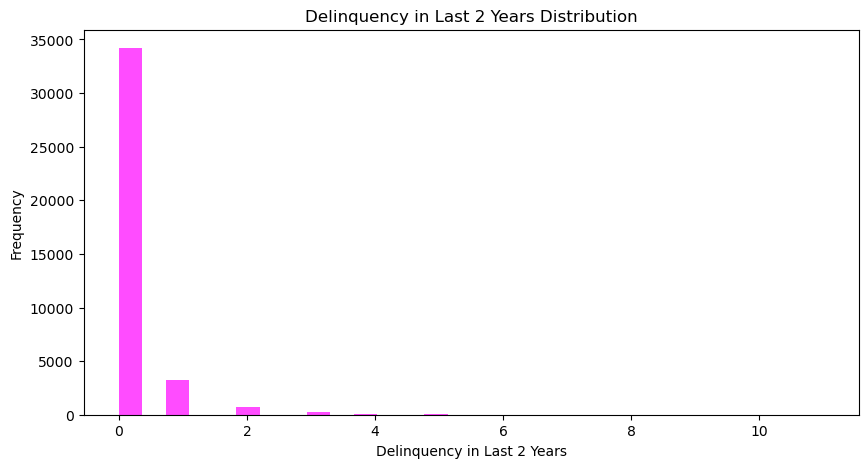

In [27]:
# Creemos un histograma de la columna delinq_2yrs
plt.figure(figsize=(10, 5))
plt.hist(raw_data['delinq_2yrs'], bins=30, color='magenta', alpha=0.7)
plt.title('Delinquency in Last 2 Years Distribution')
plt.xlabel('Delinquency in Last 2 Years')
plt.ylabel('Frequency')
plt.show()

Mantendremos la columna delinq_2yrs, ya que no tiene valores nulos.

In [28]:
# Examinemos la columna open_acc
open_acc_summary = raw_data['open_acc'].describe()
print(open_acc_summary)

count   38479.00
mean        9.34
std         4.50
min         0.00
25%         6.00
50%         9.00
75%        12.00
max        47.00
Name: open_acc, dtype: float64


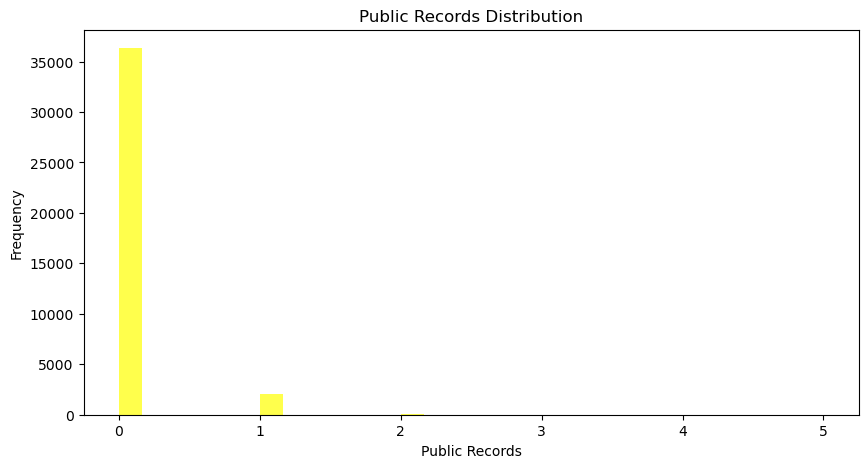

In [29]:
# Creemos un histograma de la columna pub_rec
plt.figure(figsize=(10, 5))
plt.hist(raw_data['pub_rec'], bins=30, color='yellow', alpha=0.7)
plt.title('Public Records Distribution')
plt.xlabel('Public Records')
plt.ylabel('Frequency')
plt.show()

In [32]:
# Examinemos la columna mths_since_last_delinq
months_since_last_delinq_summary = raw_data['mths_since_last_delinq'].describe()
print(months_since_last_delinq_summary)

count   14117.00
mean       35.01
std        22.43
min         0.00
25%        17.00
50%        33.00
75%        51.00
max       120.00
Name: mths_since_last_delinq, dtype: float64


# Resumen/Notas para el siguiente paso:

* Eliminar registros 0 y 54
* Lidiar con los valores NaN en emp_length, mths_since_last_delinq, y last_pymnt_d
* Considerar crear la columna 'time_to_delinq'
* Considerar dividir las fechas en columnas de mes y año
* Crear long_term en lugar de la duración del préstamo
* Eliminar outliers en income
* Crear employment_verified
* Eliminar la mayoría de columnas relacionadas con el historial crediticio
* Consolidar los valores de loan_status y eliminar repay_fail